https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#sphx-glr-download-tutorial-10-key-features-005-visualization-py

In [12]:
%reload_ext autoreload
%autoreload 2

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
from pathlib import Path

import optuna

# You can use Matplotlib instead of Plotly for visualization by simply replacing `optuna.visualization` with
# `optuna.visualization.matplotlib` in the following examples.
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_rank
from optuna.visualization.matplotlib import plot_slice
from optuna.visualization.matplotlib import plot_timeline



In [14]:
from reprpo.training import train
import tyro
from reprpo.experiments import experiment_configs
from reprpo.hp.space import search_spaces

from reprpo.interventions import Interventions, DPOConfig, ReprPOConfig, ProjGradConfig
from reprpo.interventions.losses import Losses
from reprpo.interventions.transforms import Transforms

## Objective

In [15]:
SEED=42
key_metric = "acc_gain_vs_ref/oos"

torch.manual_seed(SEED)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [16]:
# silence please
import os
from loguru import logger
logger.remove()
logger.remove()
logger.add(os.sys.stderr, level="WARNING")

# os.environ["WANDB_MODE"] = "disabled"
os.environ["HF_DATASETS_OFFLINE"] = "1"
os.environ["TQDM_DISABLE"] = "true"

In [17]:
f_db = f"sqlite:///optuna.db"
f = f_db.replace('sqlite:///', './')
print(f)
Path(f).parent.mkdir(parents=True, exist_ok=True)
f_db

./optuna.db


'sqlite:///optuna.db'

In [18]:
from reprpo.hp.target import override, default_tuner_kwargs
from reprpo.experiments import experiment_configs
import copy
import wandb

import optuna.pruners
from optuna_integration.wandb import WeightsAndBiasesCallback

In [19]:


import functools

def list2tuples(d):
    for k, v in d.items():
        if isinstance(v, list):
            d[k] = tuple(v)
    return d

def objective_func(kwargs, trial, starter_experiment_name):
    cfg = copy.deepcopy(experiment_configs[starter_experiment_name][1])
    override(cfg, default_tuner_kwargs)
    
    override(cfg, kwargs)
    kwargs = list2tuples(kwargs)
    r = train(cfg, trial=trial)
    return r

def objective(trial: optuna.Trial, starter_experiment_name, trial2args, key_metric=key_metric) -> float:
    kwargs = trial2args(trial)
    r = objective_func(kwargs, trial, starter_experiment_name)
    return r[key_metric]



Note on pruning. It's only really usefull with validation metrics and for long jobs over many epochs. I've got a small proxy job so there is no need.

In [33]:
MAX_TRIALS= 250
use_wandb = True


for starter_experiment_name, trial2args in search_spaces.items():

    study_name = f"{starter_experiment_name}"
    study = optuna.create_study(
        study_name=study_name,
        direction="maximize",
        load_if_exists=True,
        storage=f_db,
        sampler=optuna.samplers.TPESampler(seed=SEED),
        pruner=optuna.pruners.NopPruner(),
    )

    n = 0
    if len(study.trials)>0:
        df = study.trials_dataframe().query('state == "COMPLETE"').sort_values('value', ascending=False)
        n = len(df)
        print(f"loaded {n} {study_name} trials")
        print('study.best_trial', study.best_trial)

    
    if n < MAX_TRIALS:
        if use_wandb:
            os.environ["WANDB_NOTEBOOK_NAME"] = f"{study_name}.ipynb"
            wandb_kwargs = {"project": "reprpo-optuna", "name": study_name}
            wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
            print(wandb.run.get_url())
        _objective = functools.partial(objective, key_metric=key_metric, starter_experiment_name=starter_experiment_name, trial2args=trial2args)

        study.optimize(_objective, 
                    n_trials=MAX_TRIALS, 
                    callbacks=[wandbc] if use_wandb else [], 
                    gc_after_trial=True, 
                    # catch=(Exception,) # this will catch keyboard error, you will neede to restart kernel
                    catch=(AssertionError, OSError, RuntimeError, KeyError)
        )

        
        if use_wandb:
            wandb.finish(quiet=True)

    print('='*80)

[I 2024-10-03 08:03:32,109] Using an existing study with name 'projgrad' instead of creating a new one.
[I 2024-10-03 08:03:32,459] Using an existing study with name 'side-ether-prefvec' instead of creating a new one.


loaded 395 projgrad trials


/tmp/ipykernel_1072560/3419435446.py:28: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)


loaded 5 side-ether-prefvec trials
None


In [22]:
print(wandb.run.get_url())

None


## plot

In [26]:
search_spaces.keys()

dict_keys(['projgrad', 'side-ether-prefvec', 'side-svd-mse', 'side-hra-rank', 'projbp', 'dpo'])

[I 2024-10-03 08:02:30,184] Using an existing study with name 'projgrad' instead of creating a new one.


395


/tmp/ipykernel_1072560/4240827454.py:15: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

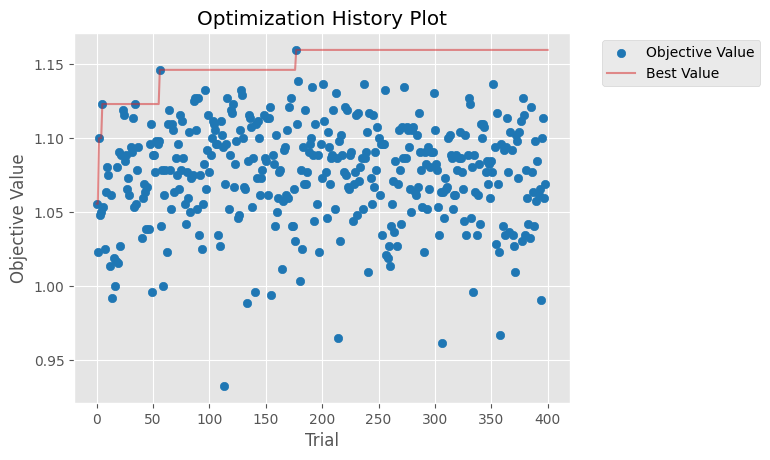

In [27]:
starter_experiment_name = 'projgrad'
trial2args = search_spaces[starter_experiment_name]

study_name = f"{starter_experiment_name}"
study = optuna.create_study(
    study_name=study_name,
    direction="maximize",
    load_if_exists=True,
    storage=f_db,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.NopPruner(),
)
print('study.best_trial', study.best_trial)
df = study.trials_dataframe().query('state == "COMPLETE"').sort_values('value', ascending=False)
print(len(df))
plot_optimization_history(study)

In [28]:
# plot_timeline(study)

In [29]:
# plot_intermediate_values(study)

In [30]:
# plot_contour(study)


/tmp/ipykernel_1072560/581810706.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='collect_hs', ylabel='Objective Value'>,
       <Axes: xlabel='collect_input'>, <Axes: xlabel='learning-rate'>,
       <Axes: xlabel='mag_clip'>, <Axes: xlabel='neg_slope'>,
       <Axes: xlabel='reverse_pref'>, <Axes: xlabel='scale_orth'>,
       <Axes: xlabel='weight_dim'>, <Axes: xlabel='β'>], dtype=object)

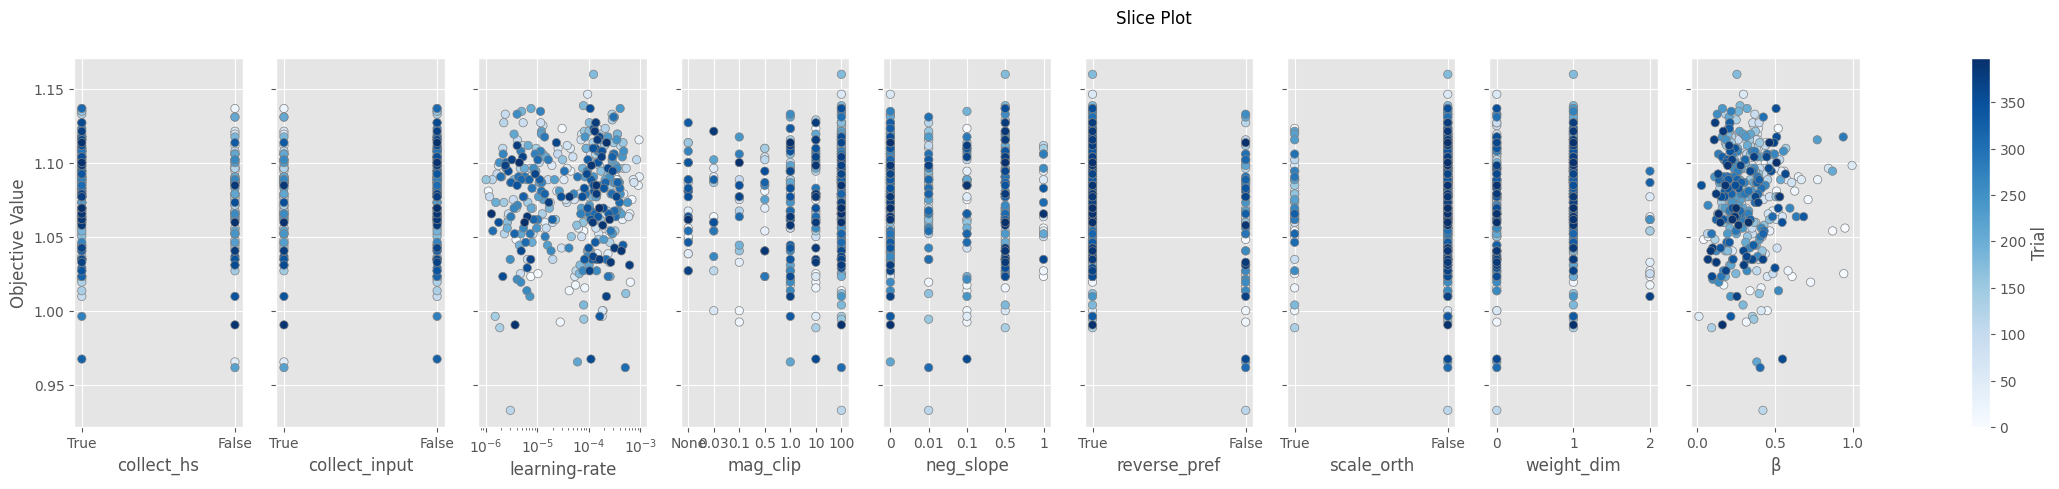

In [31]:
plot_slice(study)


/tmp/ipykernel_1072560/3836449081.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

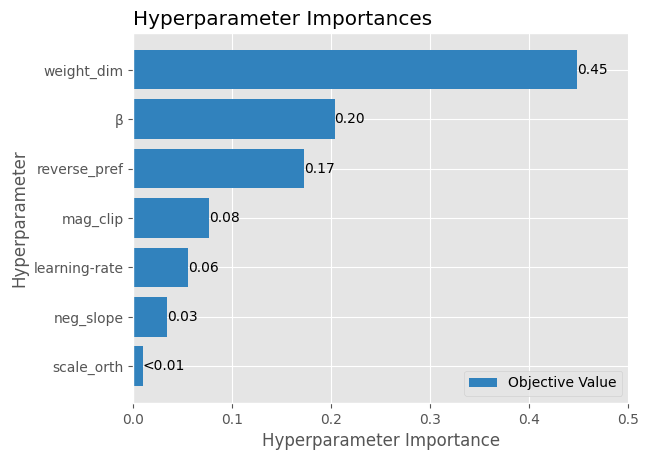

In [32]:
plot_param_importances(study)

### Apendix 1: dataclass 2 optuna

In [20]:
# import inspect
# import typing
# from typing import Literal

# def optuna_suggest_from_dataclass(t):
#     n = t.__name__
#     print(f'## {n}')
#     sig = inspect.signature(t)
#     for name, param in sig.parameters.items():
#         if param.annotation== bool:
#             print(f'"{name}": trial.suggest_categorical("{name}", [True, False]),')
#         elif param.annotation==int:
#             print(f'"{name}": trial.suggest_int("{name}", 1, 10),')
#         elif param.annotation ==float:
#             print(f'"{name}": trial.suggest_float("{name}", 0.1, 10.0),')
#         elif param.annotation == str:
#             print(f'"{name}": trial.suggest_categorical("{name}", ["a", "b", "c"]),')
#         elif param.annotation == tuple:
#             print(f'"{name}": trial.suggest_categorical("{name}", [(1, 2), (3, 4), (5, 6)]),')
#         elif typing.get_origin(param.annotation) == Literal:
#             print(f'"{name}": trial.suggest_categorical("{name}", {param.annotation.__args__}),')
#         else:
#             print(f"!!Unknown type {param}")
#             # print(name, param.default, param.annotation)

# optuna_suggest_from_dataclass(ReprPOConfig)
# for t in Transforms:
#     print(f'## {t}')
#     optuna_suggest_from_dataclass(t.value)
# for l in Losses:
#     print(f'## {l}')
#     optuna_suggest_from_dataclass(l.value)


# optuna_suggest_from_dataclass(DPOProjGradConfig)